# Track Analysis
Here we try to find the track's best racing line using different methods:
- low pass filter
- delta progress optimisation
- Euler's spirals (TODO)

## Import modules

In [1]:
import math
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
FS_June2020.npy			Spain_track.npy
H_track.npy			Straight_track.npy
LGSWide.npy			Tokyo_Training_track.npy
London_Loop_Train.npy		Vegas_track.npy
Mexico_track_eval.npy		Virtual_May19_Train_track.npy
Mexico_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("FS_June2020")

Loaded 354 waypoints


## Sector builder
Let's define sectors around the track. Mapping closest waypoint coordinates as a sector mark works well and can be used to construct interesting reward that stimulates improving every part of the track evenly.

In [5]:
def plot_track(t, fig=None):
    ratio = (lambda x,y: x / y)(*t.size())
    if fig is None:
        fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot()
    ax.axis('equal')
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

In [6]:
DENSITY = 2.0
key = lambda wpt: [int(round(c * DENSITY)) / DENSITY for c in wpt]
keys = np.array([key(w) for w in track.center_line])

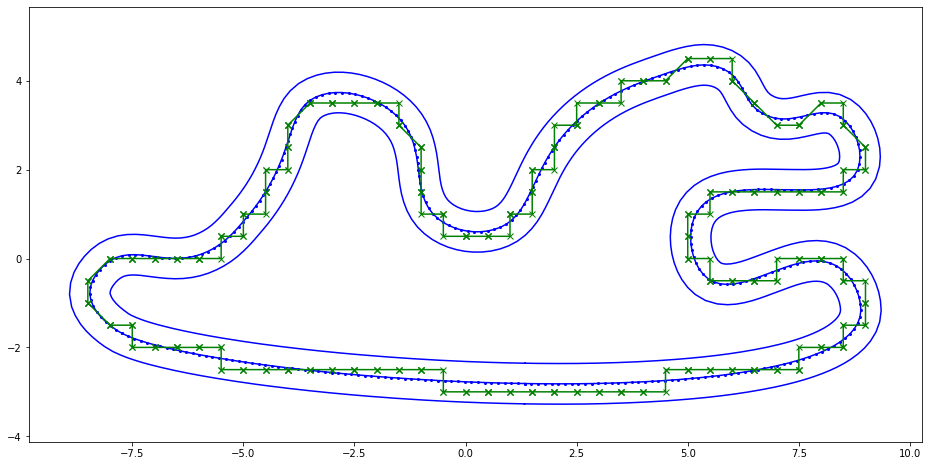

In [7]:
ax = plot_track(track)
ax.plot(*track.center_line.T, 'bo', markersize=2)
ax.plot(*keys.T, 'gx-')

# Analyze track
Let's convert the track into heading data.

### Helpers

In [8]:
def track_distance(waypoints, i, N=2):
    next_waypoint = (i + N) % len(waypoints)
    A = np.array(waypoints[i])
    B = np.array(waypoints[next_waypoint])
    return np.linalg.norm(B - A) / N

In [9]:
def track_heading(waypoints, i, N=2, above=None, below=None):
    """
    Calculate track waypoints heading in radians.
    i : waypoint id
    N : waypoint look ahead
    above : indicies to tweak, values should be above PI
    below : indicies to tweak, values should be below PI
    """
    next_waypoint = (i + N) % len(waypoints)
    A = waypoints[i]
    B = waypoints[next_waypoint]
    t_heading = math.atan2(B[1] - A[1], B[0] - A[0])
    if above is not None and i in above and t_heading < 0:
        t_heading += math.pi*2
    if below is not None and i in below and t_heading > 0:
        t_heading -= math.pi*2
    return t_heading

In [10]:
def heading2track(heading, norms, w0, constant=None):
    """
    heading : polar coords angle
    norms : polar coords radius
    w0 : initial position
    """
    wpts = [np.array(w0)]
    for h,n in zip(heading, norms):
        polar = n * np.exp(1j * h)
        polar = np.array([np.real(polar), np.imag(polar)])
        if constant is not None:
            polar += constant * n
        wpts.append(np.array(wpts[-1]) + polar)
    return np.array(wpts[1:])

In [11]:
def int_heading(dheading, h0, dt, constant=0.0):
    ih = np.zeros(heading.shape)
    ih[0] = h0
    for i in range(0,len(dheading)):
        ih[i+1] = ih[i] + dheading[i] + constant * dt[i]
    return ih

### Tune parameters above and below
Tune parameters so that the heading plot is continuous. Problem occurs at heading 180 deg, because it jumps to -180 deg, making it a non-differentiable step function.

In [12]:
above = list(range(0,0))
below = list(range(225,270)) + list(range(320,370))

In [13]:
ix = np.arange(len(track.center_line))
dt = np.array([track_distance(track.center_line, i, N=3) for i in ix])
t = np.cumsum(dt)
heading = np.array([track_heading(track.center_line, i, N=3, above=above, below=below) for i in ix])
d_heading = heading[1:] - heading[:-1]

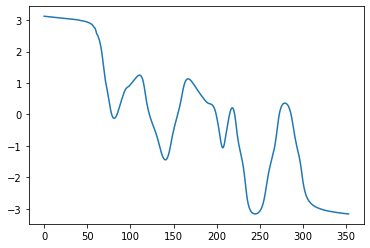

In [14]:
plt.plot(ix, heading)

#### Distance and distance derivative

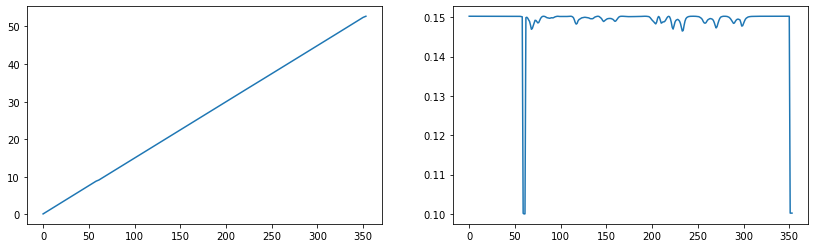

In [15]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(ix, t)
plt.subplot(122)
plt.plot(ix, dt)

#### After tuning
Plot heading over distance.

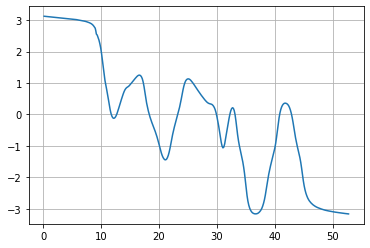

In [16]:
plt.plot(t, heading)
plt.grid()

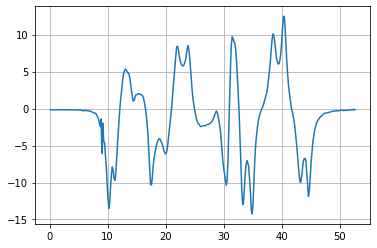

In [17]:
plt.plot(t[:-1], np.degrees(d_heading))
plt.grid()

# PART 1: Low pass filter
Here we will try to get optimal path using a simple RC filter.

Credits: https://medium.com/myplanet-musings/the-best-path-a-deepracer-can-learn-2a468a3f6d64

### Apply low-pass filter

In [18]:
def low_pass_filter(data, rc=1.0):
    xin = data[1]
    dt = data[0]
    alpha = dt / (rc + dt)
    yout = np.zeros(xin.shape)
    yout[0] = xin[0]
    for i in range(1,len(yout)):
        yout[i] = alpha[i] * xin[i] + (1.0 - alpha[i]) * yout[i-1]
    return yout

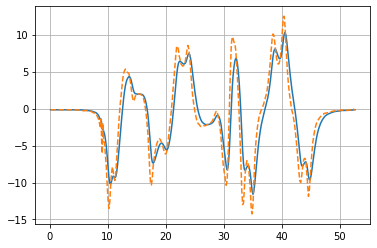

In [19]:
dh = d_heading
for i in range(0,1):
    dh = low_pass_filter([dt, dh], 0.45)
plt.plot(t[:-1], np.degrees(dh))
plt.plot(t[:-1], np.degrees(d_heading), '--')
plt.grid()

## Convert and plot

In [20]:
start = track.center_line[0] + np.array([0.3,-0.3])

In [21]:
hconst = 0.0 # heading constant
pconst = 0.0 # position constant
for i in [0,1,2]:
    i_heading = int_heading(dh, heading[0], dt, hconst)
    from_heading = heading2track(i_heading, dt, start, pconst)
    # Match first heading with last
    if i == 0:
        err = i_heading[0] - i_heading[-1]
        err = min(err, err - 2*math.pi)
        hconst = err / t[-1]
    # Match first position with last
    if i == 1:
        pconst = (from_heading[0] - from_heading[-1]) / t[-1]

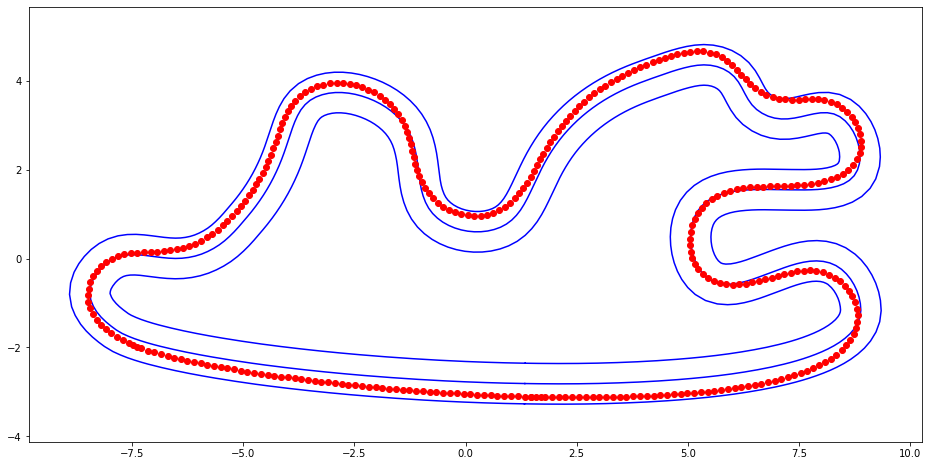

In [22]:
ax = plot_track(track)
ax.plot(*from_heading.T, 'ro')

# PART 2: Delta progress optimization
Now let's try finding a heading that minimizes travelled distance and maximizes track progress.

To optimize headings we will use scipy, but pytorch or tensorflow with gradient recording could also be used.

This is highly demanding computational task, calculating headings takes time.

## Helpers

In [23]:
def heading2vec(head):
    return np.array([np.cos(head), np.sin(head)])

In [24]:
def closest_waypoint(w, pos):
    d = np.ones(w.shape) * np.array(pos) - w
    d = np.linalg.norm(d, axis=1)
    return np.argmin(d)

In [25]:
def cost_delta(heading, prev_head, waypoints, position, track_width=0.5, look_ahead=3, r=0.2):
    """Calculate track progress and resulting cost for travelled distance."""
    dp = heading2vec(heading)
    p = np.array(position) + r * dp
    closest = closest_waypoint(waypoints, position)
    nextw = (closest + look_ahead) % len(waypoints)
    track_d = waypoints[nextw] - waypoints[closest]
    t_heading = math.atan2(track_d[1], track_d[0])
    # calculate distance from center
    dist = np.linalg.norm(position - waypoints[closest]) / track_width
    # calculate heading derivative
    steerlim = np.cross(heading2vec(0), heading2vec(np.radians(30)))
    dhead = np.cross(heading2vec(prev_head), dp) / steerlim
    # our progress is travelled distance vector along track heading
    progress = dp @ heading2vec(t_heading)
    # finally calculate weighted cost
    cost = 0.5 * dist + 0.5 * dhead - progress
    return p, cost

## Initialize heading params

In [26]:
STEPS = 300
w_headings = np.ones(STEPS + 1) * heading[0]

## Optimize

# Choosing action space
Let's find most accurate action space.

- speed:
    To estimate maximum speed at a steering $s$ we will use empirically found maximum speed $v_{max}$ at a certain steering $s_{max}$ as a reference, then use this formula
    $v_{est} = v_{max} \frac{\sin{s_{max}}}{\sin{s}}$.

- angle: 
    Our perfect racing line heading was calculated before so all we need is to get its derivative in degrees.
    
Next we will distribute actions on speed to steering space and use k-nearest neighbours to optimize for desired action space.

In [2]:
V_MAX = 1.4
S_MAX = math.radians(30.0)
estimate = lambda s: V_MAX * np.sin(S_MAX) / np.sin(np.radians(s))

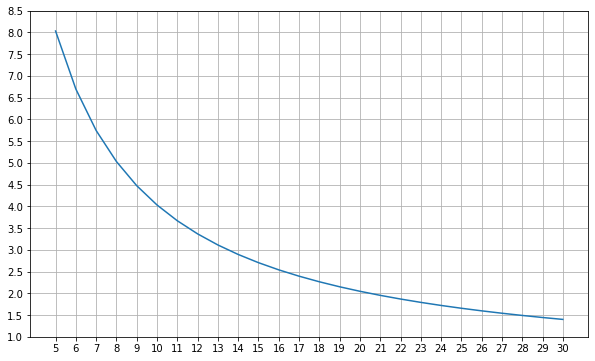

In [3]:
s = np.linspace(5.0, 30.0, num=26)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.plot(s, estimate(s))
ax.set_xticks(np.arange(5,31))
ax.set_yticks(np.arange(1,9,0.5))
ax.grid()
plt.savefig('max_steering.png')

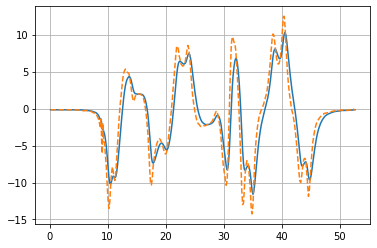

In [31]:
steering = np.array([t[:-1], np.degrees(dh)])
plt.plot(*steering)
plt.plot(t[:-1], np.degrees(d_heading), '--')
plt.grid()